In [1]:
import seaborn as sns
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Set plot options
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = "#00bfbf"

In [3]:
data = pd.read_csv("fake_news_data.csv")

In [4]:
data.head()

,title,text,date,fake_or_factual
0,New Study Claims Chocolate Cures Cancer,A groundbreaking study from an obscure lab cla...,15-Jan-24,Fake News
1,Scientists Discover New Species of Fish in Pac...,Marine biologists from NOAA announced the disc...,10-Feb-24,Factual News
2,Alien Fossils Found in Antarctica,A viral blog post claims researchers uncovered...,25-Mar-24,Fake News
3,New Solar Panel Design Boosts Efficiency by 30%,Engineers at MIT developed a solar panel with ...,5-Apr-24,Factual News
4,Tom Hanks Secretly Runs a Time Travel Agency,A conspiracy website claims Tom Hanks operates...,12-May-24,Fake News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            331 non-null    object
 1   text             331 non-null    object
 2   date             330 non-null    object
 3   fake_or_factual  330 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


Text(0.5, 1.0, 'Count of Article Classification')

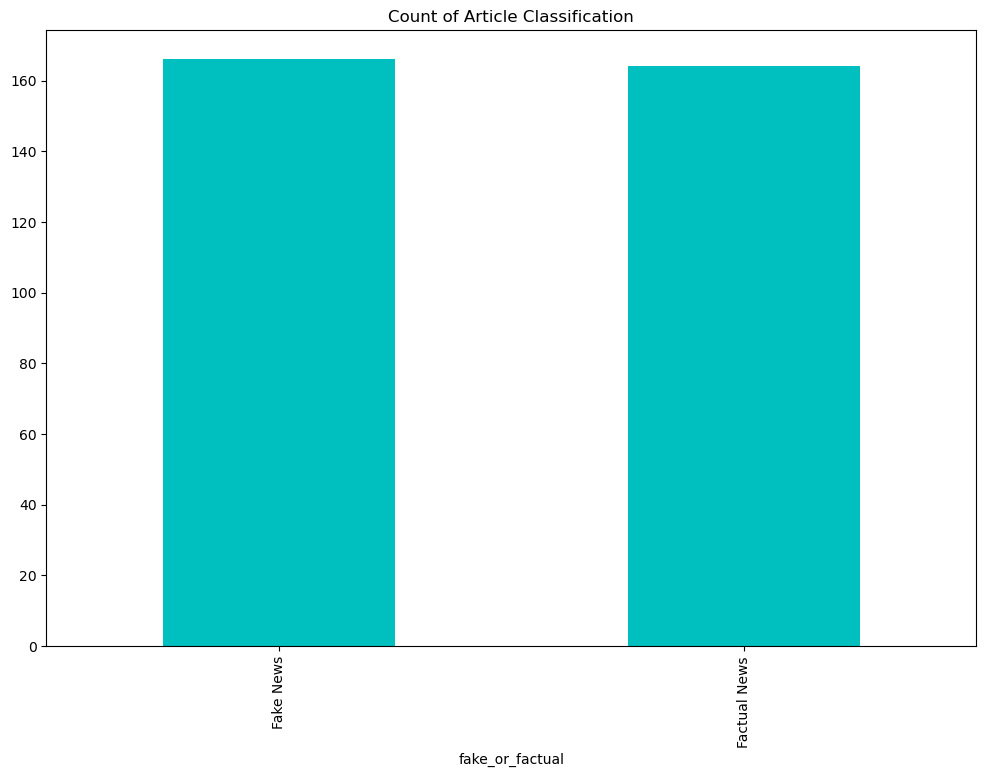

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title("Count of Article Classification")

### POS Tagging

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [9]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [10]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [11]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [12]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [13]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [14]:
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [15]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [16]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,A,,DET
1,groundbreaking,,NOUN
2,study,,NOUN
3,from,,ADP
4,an,,DET


In [17]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
12,.,PUNCT,334
10,",",PUNCT,269
28,A,DET,163
223,a,DET,149
596,in,ADP,144
4,',PUNCT,138
827,say,VERB,119
1023,with,ADP,88
351,claims,VERB,87
708,not,PART,85


In [18]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
8,",",PUNCT,352
11,.,PUNCT,328
671,in,ADP,321
5,*,PROPN,150
41,A,DET,131
308,The,DET,125
0,%,NOUN,113
1098,was,AUX,109
19,2024,NUM,108
6,*,PUNCT,85


In [19]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     496
VERB     172
PROPN    145
ADJ      122
ADP       21
AUX       14
NUM       14
ADV       13
DET       10
PRON       9
Name: token, dtype: int64

In [20]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     476
PROPN    255
VERB     177
ADJ      114
NUM       32
ADP       25
ADV       14
AUX        8
PRON       7
DET        6
Name: token, dtype: int64

In [21]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
350,claims,NOUN,49
749,photos,NOUN,26
226,activity,NOUN,25
904,story,NOUN,24
1,%,NOUN,23
300,blog,NOUN,21
872,site,NOUN,19
529,ghosts,NOUN,18
935,tabloid,NOUN,18
469,experts,NOUN,18


In [22]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
0,%,NOUN,113
1009,study,NOUN,48
471,company,NOUN,42
827,patients,NOUN,39
695,journal,NOUN,35
1032,tech,NOUN,34
539,drug,NOUN,34
4,*,NOUN,28
346,accuracy,NOUN,20
1042,therapy,NOUN,13


### Named Entities

In [23]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)

In [24]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by="counts", ascending=False)

In [25]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6],
    'LAW': sns.color_palette("Set2").as_hex()[7],
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

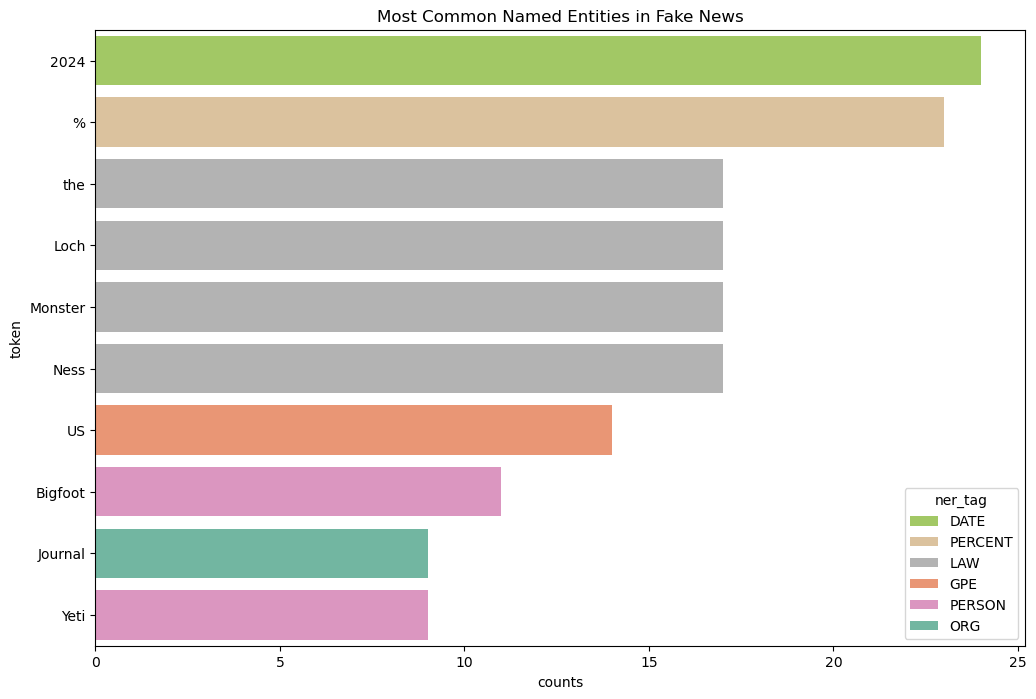

In [26]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entities in Factual News')]

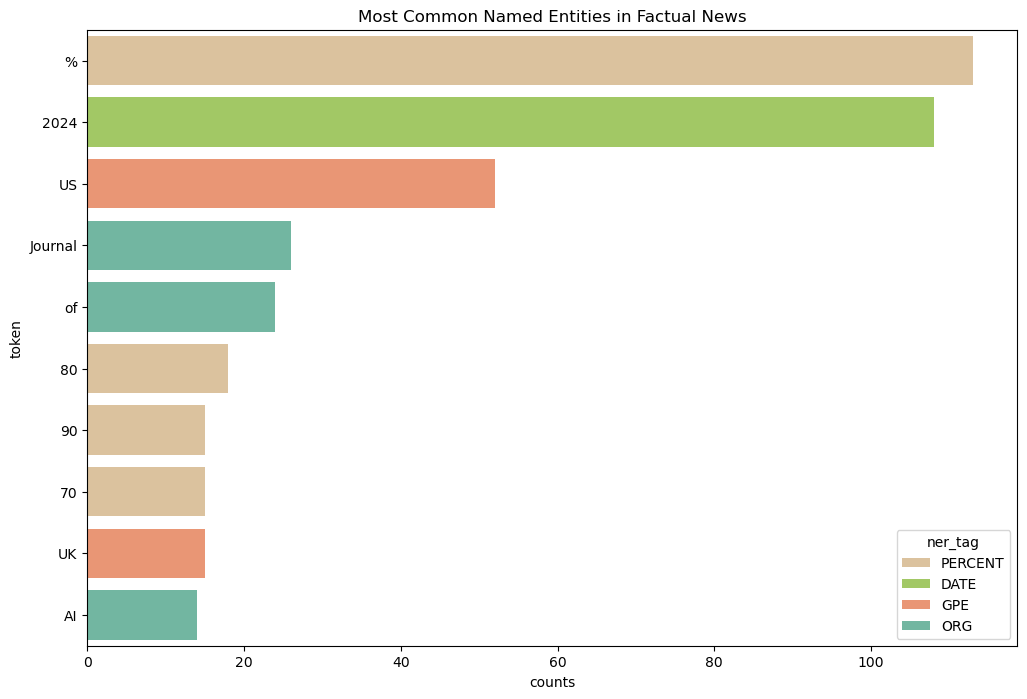

In [27]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Factual News")

### Text Pre-Processing

In [28]:
data.head()

,title,text,date,fake_or_factual
0,New Study Claims Chocolate Cures Cancer,A groundbreaking study from an obscure lab cla...,15-Jan-24,Fake News
1,Scientists Discover New Species of Fish in Pac...,Marine biologists from NOAA announced the disc...,10-Feb-24,Factual News
2,Alien Fossils Found in Antarctica,A viral blog post claims researchers uncovered...,25-Mar-24,Fake News
3,New Solar Panel Design Boosts Efficiency by 30%,Engineers at MIT developed a solar panel with ...,5-Apr-24,Factual News
4,Tom Hanks Secretly Runs a Time Travel Agency,A conspiracy website claims Tom Hanks operates...,12-May-24,Fake News


In [29]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x["text"]), axis=1)

In [30]:
data['text_clean'] = data['text_clean'].str.lower()

In [31]:
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x["text_clean"]), axis=1)

In [32]:
nltk.download('stopwords')
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [34]:
nltk.download('punkt')
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [36]:
tokens_clean = sum(data['text_clean'], [])

In [37]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams[:10])

          index  count
0      (claim,)    160
1        (say,)    147
2       (2024,)    133
3    (journal,)    110
4  (published,)     72
5          (u,)     68
6      (study,)     65
7   (approved,)     57
8    (company,)     52
9   (featured,)     51


C:\Users\Admin\AppData\Local\Temp\ipykernel_8900\838644735.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

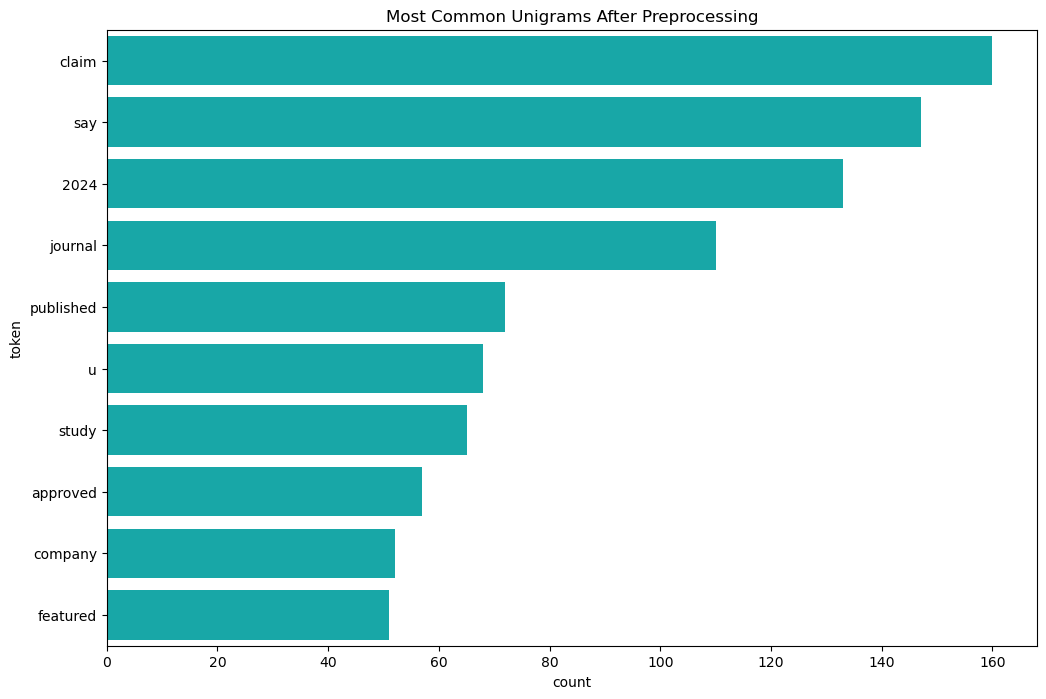

In [38]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

sns.barplot(x="count",
            y="token",
            data=unigrams,
            orient="h",
            palette=[default_plot_color],
            hue="token", legend=False)\
.set(title="Most Common Unigrams After Preprocessing")

In [39]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams[:10])

                    index  count
0        (approved, 2024)     56
1      (study, published)     54
2        (launched, 2024)     49
3        (tabloid, claim)     43
4          (claim, alien)     37
5        (drug, approved)     33
6            (u, company)     32
7  (paranormal, activity)     31
8        (patient, study)     29
9        (tech, featured)     28


## Sentiment Analysis

In [40]:
vader_sentiment = SentimentIntensityAnalyzer()

In [41]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [42]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,New Study Claims Chocolate Cures Cancer,A groundbreaking study from an obscure lab cla...,15-Jan-24,Fake News,"[groundbreaking, study, obscure, lab, claim, e...",-0.4019
1,Scientists Discover New Species of Fish in Pac...,Marine biologists from NOAA announced the disc...,10-Feb-24,Factual News,"[marine, biologist, noaa, announced, discovery...",0.0000
2,Alien Fossils Found in Antarctica,A viral blog post claims researchers uncovered...,25-Mar-24,Fake News,"[viral, blog, post, claim, researcher, uncover...",-0.3818
3,New Solar Panel Design Boosts Efficiency by 30%,Engineers at MIT developed a solar panel with ...,5-Apr-24,Factual News,"[engineer, mit, developed, solar, panel, novel...",0.8442
4,Tom Hanks Secretly Runs a Time Travel Agency,A conspiracy website claims Tom Hanks operates...,12-May-24,Fake News,"[conspiracy, website, claim, tom, hank, operat...",-0.7184


In [43]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [44]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [45]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,New Study Claims Chocolate Cures Cancer,A groundbreaking study from an obscure lab cla...,15-Jan-24,Fake News,"[groundbreaking, study, obscure, lab, claim, e...",-0.4019,negative
1,Scientists Discover New Species of Fish in Pac...,Marine biologists from NOAA announced the disc...,10-Feb-24,Factual News,"[marine, biologist, noaa, announced, discovery...",0.0000,neutral
2,Alien Fossils Found in Antarctica,A viral blog post claims researchers uncovered...,25-Mar-24,Fake News,"[viral, blog, post, claim, researcher, uncover...",-0.3818,negative
3,New Solar Panel Design Boosts Efficiency by 30%,Engineers at MIT developed a solar panel with ...,5-Apr-24,Factual News,"[engineer, mit, developed, solar, panel, novel...",0.8442,positive
4,Tom Hanks Secretly Runs a Time Travel Agency,A conspiracy website claims Tom Hanks operates...,12-May-24,Fake News,"[conspiracy, website, claim, tom, hank, operat...",-0.7184,negative


<Axes: xlabel='vader_sentiment_label'>

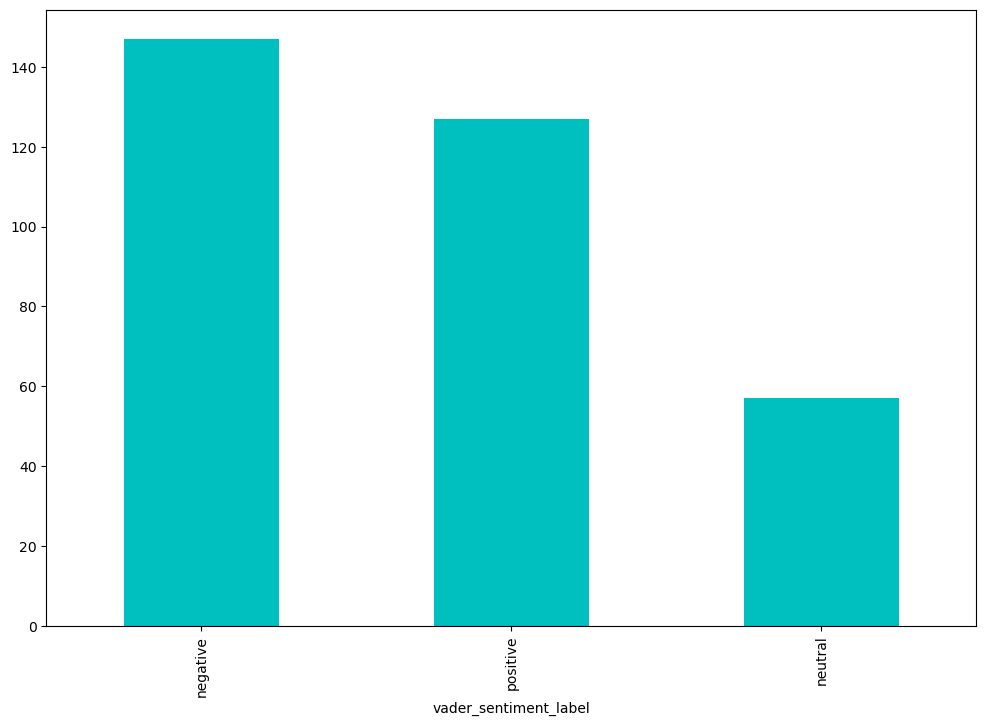

In [46]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_color)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8900\6889798.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

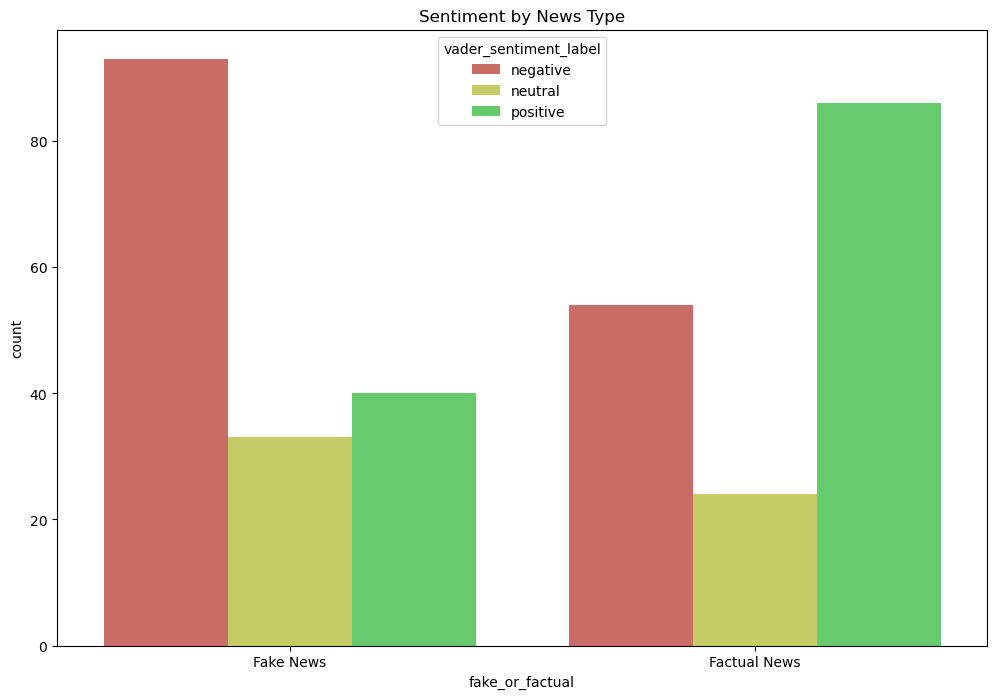

In [47]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
).set(title = "Sentiment by News Type")

## LDA

In [48]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

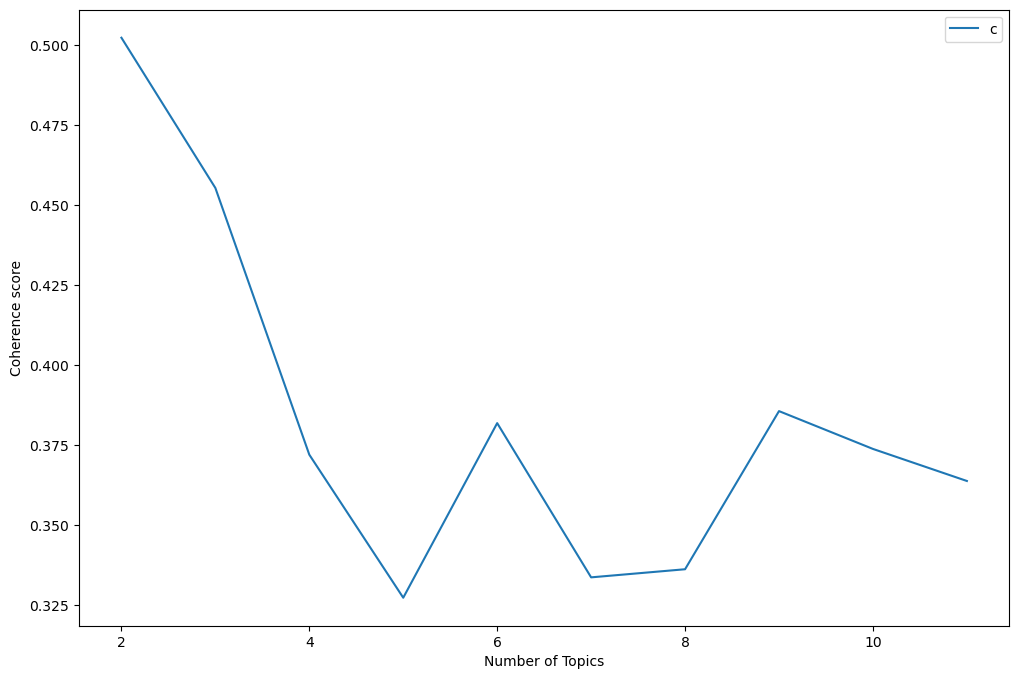

In [49]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# create lda model
num_topics_fake = 6 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.045*"claim" + 0.038*"say" + 0.016*"tabloid" + 0.016*"alien" + 0.012*"loch" + 0.012*"monster" + 0.011*"leaked" + 0.011*"citing" + 0.011*"ness" + 0.010*"blog"'),
 (1,
  '0.048*"say" + 0.048*"claim" + 0.020*"tabloid" + 0.020*"paranormal" + 0.016*"ghost" + 0.016*"activity" + 0.015*"alien" + 0.013*"due" + 0.013*"new" + 0.013*"citing"'),
 (2,
  '0.042*"claim" + 0.033*"say" + 0.019*"viral" + 0.017*"footage" + 0.012*"wildlife" + 0.011*"alien" + 0.011*"study" + 0.010*"citing" + 0.010*"built" + 0.010*"video"'),
 (3,
  '0.036*"claim" + 0.034*"say" + 0.012*"2024" + 0.012*"journal" + 0.011*"paranormal" + 0.011*"tabloid" + 0.010*"featured" + 0.010*"launched" + 0.010*"activity" + 0.010*"alien"'),
 (4,
  '0.028*"claim" + 0.027*"photo" + 0.026*"say" + 0.016*"post" + 0.015*"cryptid" + 0.015*"viral" + 0.015*"yeti" + 0.015*"official" + 0.015*"wildlife" + 0.015*"grainy"'),
 (5,
  '0.016*"published" + 0.016*"2024" + 0.016*"study" + 0.015*"approved" + 0.015*"patient" + 0.014*"therapy" + 0.013*"clai

## TF-IDF & LSA

In [51]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [52]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

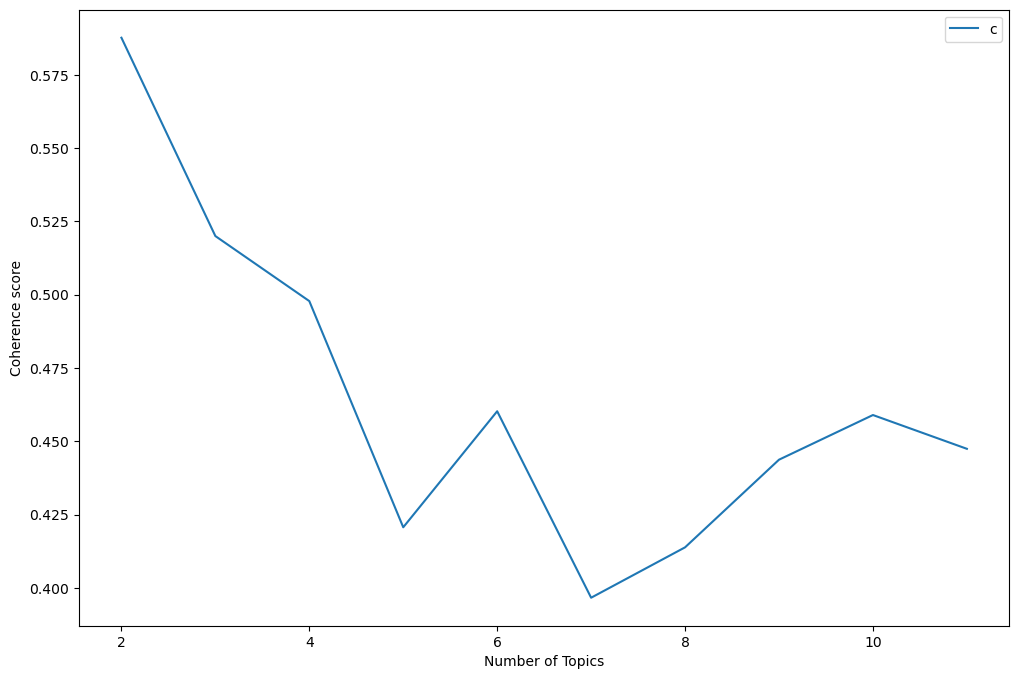

In [53]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [54]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '-0.304*"cryptid" + -0.299*"wildlife" + -0.288*"seen" + -0.283*"viral" + -0.209*"footage" + -0.197*"blurry" + -0.196*"bigfoot" + -0.193*"yeti" + -0.189*"video" + -0.187*"post"'),
 (1,
  '-0.194*"paranormal" + -0.190*"activity" + -0.165*"alien" + 0.160*"cryptid" + -0.158*"moving" + -0.156*"ghost" + -0.155*"tabloid" + -0.151*"staff" + -0.150*"due" + 0.150*"seen"'),
 (2,
  '-0.235*"paranormal" + -0.228*"activity" + 0.202*"alien" + -0.187*"moving" + -0.185*"staff" + -0.170*"due" + -0.163*"ghost" + 0.161*"extraterrestrial" + -0.159*"haunt" + -0.156*"scare"'),
 (3,
  '0.297*"2024" + 0.281*"journal" + 0.244*"u" + 0.234*"approved" + 0.234*"published" + 0.229*"study" + 0.212*"patient" + 0.203*"therapy" + 0.169*"launched" + 0.169*"featured"'),
 (4,
  '0.253*"loch" + 0.237*"monster" + 0.224*"ness" + -0.192*"built" + -0.176*"citing" + -0.169*"archaeologist" + -0.168*"tv" + 0.149*"sighting" + -0.147*"engineering" + -0.142*"helped"')]

## Predict fake or factual news

In [55]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,New Study Claims Chocolate Cures Cancer,A groundbreaking study from an obscure lab cla...,15-Jan-24,Fake News,"[groundbreaking, study, obscure, lab, claim, e...",-0.4019,negative
1,Scientists Discover New Species of Fish in Pac...,Marine biologists from NOAA announced the disc...,10-Feb-24,Factual News,"[marine, biologist, noaa, announced, discovery...",0.0000,neutral
2,Alien Fossils Found in Antarctica,A viral blog post claims researchers uncovered...,25-Mar-24,Fake News,"[viral, blog, post, claim, researcher, uncover...",-0.3818,negative
3,New Solar Panel Design Boosts Efficiency by 30%,Engineers at MIT developed a solar panel with ...,5-Apr-24,Factual News,"[engineer, mit, developed, solar, panel, novel...",0.8442,positive
4,Tom Hanks Secretly Runs a Time Travel Agency,A conspiracy website claims Tom Hanks operates...,12-May-24,Fake News,"[conspiracy, website, claim, tom, hank, operat...",-0.7184,negative


In [62]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['fake_or_factual'] = label_encoder.fit_transform(data['fake_or_factual'])

X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [63]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [64]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3, random_state=0)

In [65]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [66]:
y_pred_lr = lr.predict(X_test)

In [67]:
accuracy_score(y_pred_lr, y_test)

0.84

In [68]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79        33
           1       0.95      0.82      0.88        66
           2       0.00      0.00      0.00         1

    accuracy                           0.84       100
   macro avg       0.55      0.58      0.56       100
weighted avg       0.86      0.84      0.84       100



C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [69]:
svm = SGDClassifier().fit(X_train, y_train)

In [70]:
y_pred_svm = svm.predict(X_test)

In [71]:
accuracy_score(y_pred_svm, y_test)

0.78

In [72]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.63      0.88      0.73        33
           1       0.91      0.74      0.82        66
           2       0.00      0.00      0.00         1

    accuracy                           0.78       100
   macro avg       0.51      0.54      0.52       100
weighted avg       0.81      0.78      0.78       100



C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\envs\myenv311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)